# BioscrapeCOBRA: a hyrid composite of chemical reaction networks with flux balance analysis

## Overview
This notebook combines a chemical reaction network model with a flux balance analysis model, and a physics engine

* SBML
* BiGG model

In [1]:
#@title install vivarium libraries

#Uncomment in Colab Below

"""
%%capture
!pip install git+https://github.com/vivarium-collective/vivarium-notebooks
!pip install vivarium-core==0.1.5
!pip install vivarium-cobra==0.0.6
!pip install vivarium-pymunk==0.0.2
!pip install vivarium-bioscrape
"""

'\n%%capture\n!pip install git+https://github.com/vivarium-collective/vivarium-notebooks\n!pip install vivarium-core==0.1.5\n!pip install vivarium-cobra==0.0.6\n!pip install vivarium-pymunk==0.0.2\n!pip install vivarium-bioscrape\n'

In [2]:
#@title imports
import numpy as np
import pylab as plt

# process/composition interface
from vivarium.core.process import (
    Process, Deriver, Composite,
)

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    FACTORY_KEY,
)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# vivarium plotting functions
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

# import processes and composites
from vivarium.processes.tree_mass import TreeMass
from vivarium_cobra.processes.volume import Volume
from vivarium_cobra.composites.cobra_composite import CobraComposite
from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, 
    get_iAF1260b_config, 
    print_growth
)
from vivarium_bioscrape.processes.bioscrape import (
    Bioscrape
)

In [3]:
# plotting function for metabolism output
def plot_metabolism(data, ncol=2):
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})
    
    # initialize subplots
    n_rows = 2
    n_cols = 2
    fig = plt.figure(figsize=(n_cols * 7, n_rows * 3))
    grid = plt.GridSpec(n_rows, n_cols)
    
    time_vec = data['time']
    
    # mass
    ax = fig.add_subplot(grid[0, 0])  
    ax.plot(time_vec, data['global'][('mass', 'femtogram')], label = 'mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
#     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # external
    ax = fig.add_subplot(grid[0, 1])  
    for mol_id, series in data['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # internal
    ax = fig.add_subplot(grid[1, 1])  
    for mol_id, series in data['internal_counts'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')
    fig.tight_layout()
    plt.rcParams.update({'font.size': original_fontsize})

# Flux Balance Analysis with COBRA

 * This process is a wrapper for the popular FBA solver [COBRA](https://cobrapy.readthedocs.io/en/latest/).
 * Metabolism is initialized with a [BiGG metabolic model](http://bigg.ucsd.edu) called *iAF1260b*, which has 2382 reactions, 1261 genes, and 166 metabolites.

In [4]:

# get the configuration for the iAF1260b BiGG model
cobra_config = get_iAF1260b_config()
cobra_config.update({'time_step': 10})
config = {'cobra': cobra_config}   

# load it into DynamicFBA
metabolism = CobraComposite(config)

# get the model's initial state
initial_state = metabolism.initial_state({}) 

# run simulation
sim_settings = {
    'initial_state': initial_state,
    'total_time': 2500}
cobra_timeseries = simulate_compartment_in_experiment(metabolism, sim_settings)


Experiment ID: 7b83adac-5d11-11eb-81b3-acde48001122
Created: 01/22/2021 at 16:25:23
Completed in 30.70 seconds


volume growth: 1.9537412863469115
mass growth: 1.9537412863469115


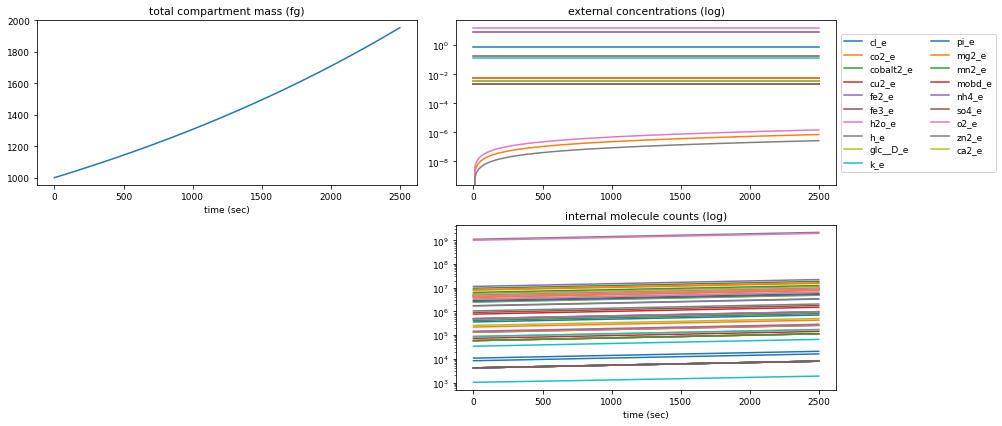

In [5]:
print_growth(cobra_timeseries['global'])
plot_metabolism(cobra_timeseries)

# Chemical Reaction Network with SBML 

In [6]:
time_step = 1
total_time = 2500

# initialize Bioscrape process
bioscrape_config = {
    'sbml_file': 'LacOperon_simple.xml',
    'time_step': time_step}
bioscrape_process = Bioscrape(bioscrape_config)

# initial state
initial_state = bioscrape_process.initial_state()

# run simulation
settings = {
    'total_time': total_time,
    'initial_state': initial_state,
    'display_info': False,
    'progress_bar': False}
bioscrape_timeseries = simulate_process_in_experiment(bioscrape_process, settings)

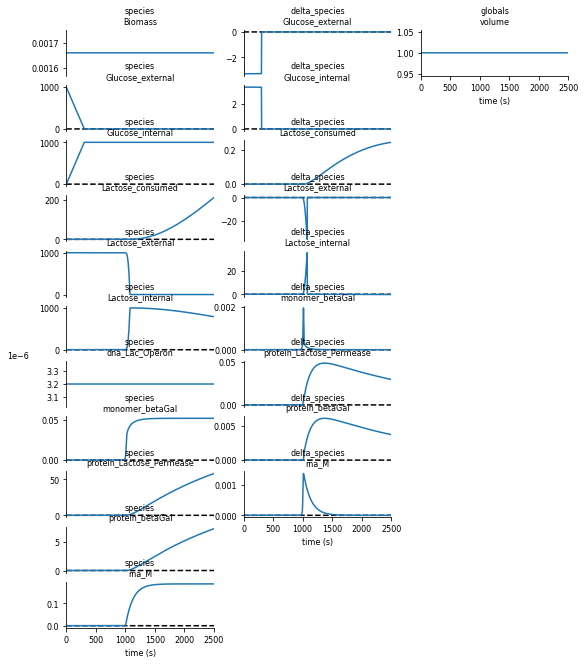

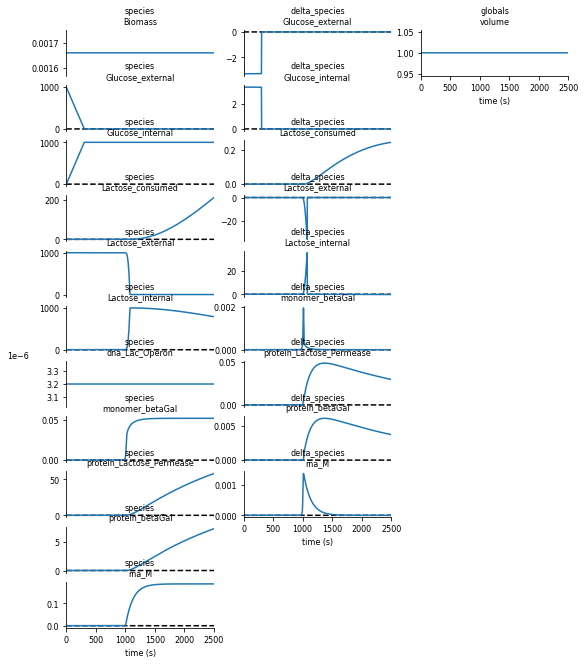

In [7]:
plot_simulation_output(bioscrape_timeseries)

# Multibody physics with pymunk

In [8]:
from vivarium_pymunk.processes.multibody_physics import Multibody

# TODO -- minimal Growth/Division example here
# This can ideally be merged in with BioscrapeCOBRA

# BioscrapeCOBRA: a CRN/FBA Composite

This also includes several adaptor "Deriver" Processes, such as FluxDeriver and BiomassAdaptor

* BiomassAdaptor demonstrates vivarium units, and also the use of a Deriver as an adaptor between Processes

In [9]:

# TODO -- FluxDeriver works for deterministic dynamics, stochastic will require something else.
# calculate weighted average back in time based on COBRA timestep?

class FluxDeriver(Deriver):
    """ Bioscrape delta species to fluxes for constraining COBRA """
    
    defaults = {
        'time_step': 1,
        'flux_keys': []}

    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'deltas': {
                flux_key: {
                    '_default': 0.0}
                for flux_key in self.parameters['flux_keys']
            },
            'fluxes': {
                flux_key: {
                    '_default': 0.0,
                    '_updater': 'set'}
                for flux_key in self.parameters['flux_keys']
            }}

    def next_update(self, timestep, states):
        deltas = states['deltas']
        update = {
            'fluxes': {
                reaction_id: delta / self.parameters['time_step']
                for reaction_id, delta in deltas.items()}}
        return update

    
class BiomassAdaptor(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units':1.0 * units.fg,
        'input_volume_units':1.0 * units.fL,
        'output_mass_units':1.0 *units.mmolar,
        'output_volume_units':1.0 *units.fL,
        'mass_species_molecular_weight':1.0 *units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * units.fg},  
                'volume': {
                    '_default': 1.0 * units.fL},
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0}
                }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        volume = states['input']['volume']
        
        # do conversion
        mass_species_molecular_weight = self.config['mass_species_molecular_weight']
        count_mass_species = mass/mass_species_molecular_weight
        mass_species_conc = count_mass_species/volume
        output_mass_units = self.config['output_mass_units']
    
        update = {
            'output': {
                'biomass': mass_species_conc.to(output_mass_units).magnitude
                }
            }
    
#         print(update)
        return update
    

# BioscrapeCOBRA 

This composite demonstrates advanced generate_topology() methods, which split ports across multiple stores with `'_path'`

In [10]:

class BioscrapeCOBRA(Composite):
    """
    TODO:
        * units for Biomass is in mmol/L of a species with mw of 1 fg/count = avagadro's number * fg / mol
        * import of Glucose is also in terms of 'Biomass' species
        * stochastically, it is in counts. Volume
        * logic for counts/concentrations if stochastic/deterministic
        * Bioscrape species 'Lactose_internal', 'Lactose_external' need to get wired to ('external',),
            But don't let Bioscrape update them. Only use FBA's resulting uptake.
    """
    
    # set cobra constrained reactions
    cobra_config = get_iAF1260b_config()
    cobra_config.update({'time_step': 10})

    defaults = {
        'bioscrape': {
            'sbml_file': 'LacOperon_simple_no_dilution.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
        },
        'cobra': cobra_config,
        'flux_deriver': {
            'flux_keys': [
                'Lactose_consumed',
                'Glucose_internal',
            ]
        },
        '_schema': {
            # override bioscrape ('species', 'Biomass') with a 'set' updater
            'bioscrape': {
                'species': {
                    'Biomass': {
                        '_updater': 'set'
                    }
                }
            }
        }
    }

    def generate_processes(self, config):

        bioscrape_process = Bioscrape(config['bioscrape'])
        cobra_process = DynamicFBA(config['cobra'])
        flux_deriver = FluxDeriver(config['flux_deriver'])

        # logic for counts/concentrations if stochastic/deterministic
        if config['bioscrape']['stochastic']:
            pass
        
        return {
            'bioscrape': bioscrape_process,
            'cobra': cobra_process,
            'mass_deriver': TreeMass(),
            'volume_deriver': Volume(),
            'flux_deriver': flux_deriver,
            'biomass_adaptor': BiomassAdaptor(),
        }

    def generate_topology(self, config):

        return {
            'bioscrape': {
                # all species go to a species store on the base level, 
                # except Biomass, which goes to the 'globals' store, with variable 'biomass'
                'species': {
                    '_path': ('species',),
                    'Biomass': ('..', 'globals', 'biomass'),
                },
                'delta_species': ('delta_species',),
                'rates': ('rates',),
                'globals': ('globals',),
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': ('external',),
                'exchanges': ('exchanges',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': ('globals',),
            },
            'flux_deriver': {
                'deltas': ('delta_species',),
                # connect Bioscrape deltas 'Lactose_consumed' and 'Glucose_internal'
                # to COBRA flux bounds 'EX_lac__D_e' and 'EX_glc__D_e'
                'fluxes':
                    {
                        'Lactose_consumed': ('flux_bounds', 'EX_lac__D_e'),
                        'Glucose_internal': ('flux_bounds', 'EX_glc__D_e'),
                    }
            },
            'mass_deriver': {
                'global': ('globals',),
            },
            'volume_deriver': {
                'global': ('globals',),
            },
            'biomass_adaptor': {
                'input': ('globals',),
                'output': ('globals',),
            }
        }


In [11]:
# configure the Composite
config = {}
composite = BioscrapeCOBRA(config)

# get initial state
initial_state = composite.initial_state()
## override FBA default external state
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10

# simulate
settings = {
    'initial_state': initial_state,
    'total_time': 2000}
bioscrape_cobra_output = simulate_compartment_in_experiment(
    composite, 
    settings)



Experiment ID: 949b1e24-5d11-11eb-81b3-acde48001122
Created: 01/22/2021 at 16:26:05


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 42.90 seconds


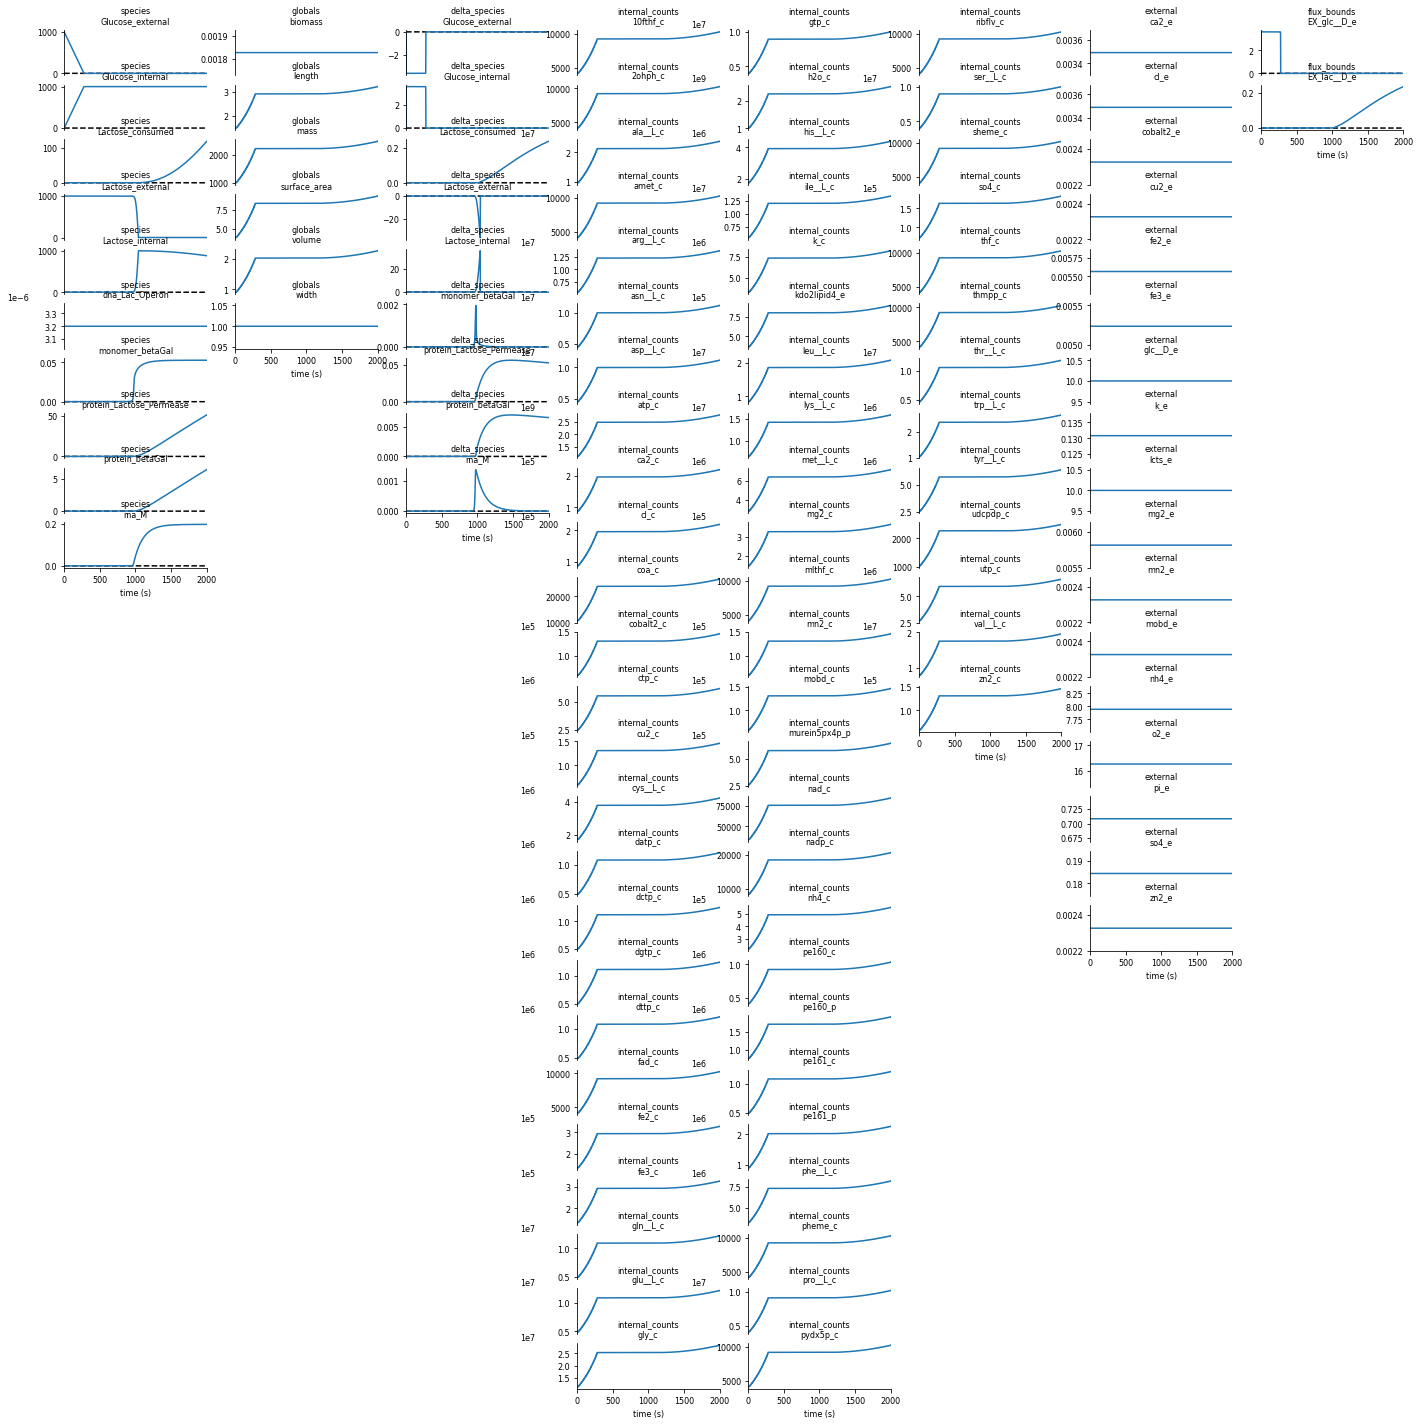

In [12]:
fig = plot_simulation_output(
        bioscrape_cobra_output)

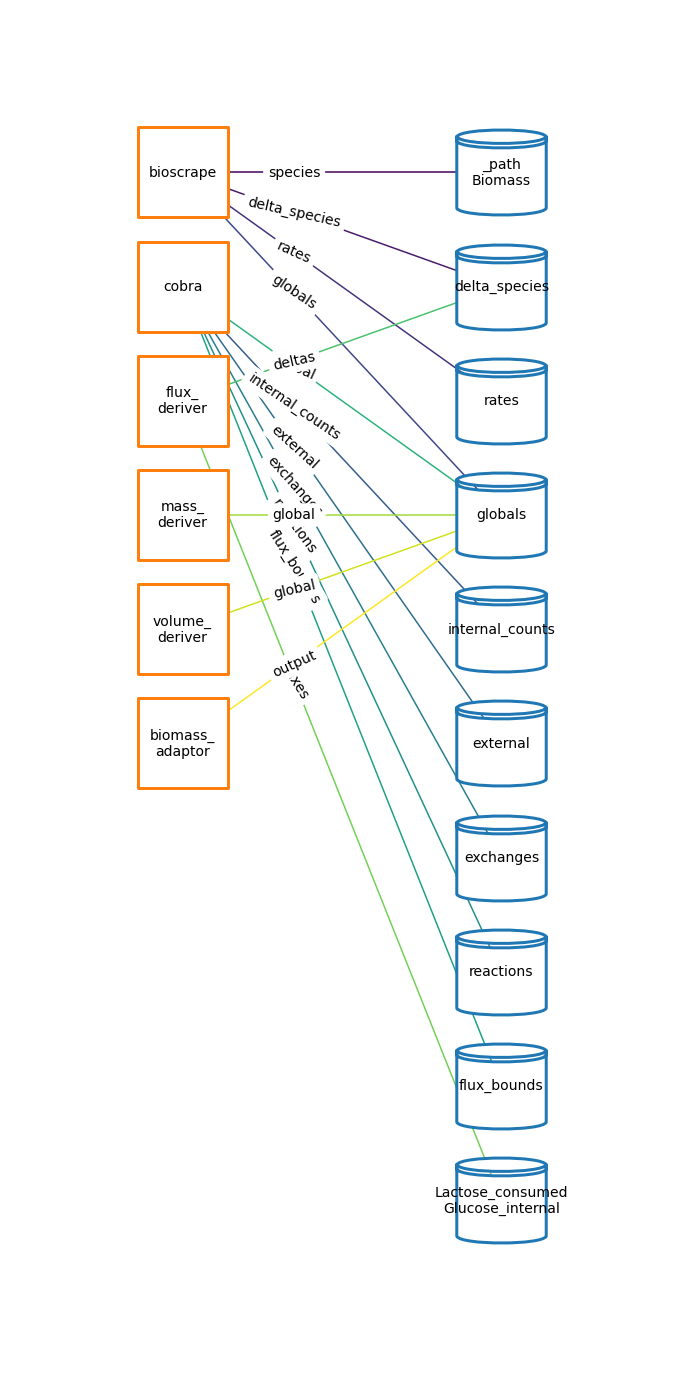

In [13]:
fig = plot_topology(composite)

# Simulate BioscrapeCOBRA in a Spatial Environment with pymunk
 * We here plug BioscrapeCOBRA into an environmental composite called Lattice, which has a multi-body physics process (MBP) and a spatial diffusion process (DFF).